# Loading libraries

In [262]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
from pandasql import sqldf
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
from itertools import combinations
import scipy.stats

con = sqlite3.Connection('Northwind_small.sqlite')
cur = con.cursor()

# Loading tables

In [263]:
cur.execute("""Select name
               From sqlite_master 
               Where type="table";""")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [264]:
cur.execute("""Select * 
               From OrderDetail
;""")
OrderDetail_df = pd.DataFrame(cur.fetchall())
OrderDetail_df.columns = [x[0] for x in cur.description]

In [265]:
OrderDetail_df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [266]:
cur.execute("""Select Discount, Avg(Quantity)
               From OrderDetail
               Group by 1
;""")
discount_avgquant_df = pd.DataFrame(cur.fetchall())
discount_avgquant_df.columns = [x[0] for x in cur.description]
discount_avgquant_df

,Discount,Avg(Quantity)
0,0.00,21.715262
1,0.01,2.000000
2,0.02,2.000000
3,0.03,1.666667
4,0.04,1.000000
5,0.05,28.010811
6,0.06,2.000000
7,0.10,25.236994
8,0.15,28.382166
9,0.20,27.024845


In [267]:
cur.execute("""Select ProductId, Avg(Quantity)
               From OrderDetail
               Where Discount = 0.00
               Group by 1
;""")
quantity_nodiscount_df = pd.DataFrame(cur.fetchall())
quantity_nodiscount_df.columns = [x[0] for x in cur.description]

In [268]:
quantity_nodiscount_df

,ProductId,Avg(Quantity)
0,1,17.772727
1,2,21.473684
2,3,28.800000
3,4,17.200000
4,5,29.333333
...,...,...
72,73,22.125000
73,74,22.600000
74,75,21.758621
75,76,22.730769


In [269]:
cur.execute("""Select ProductId, Avg(Quantity)
               From OrderDetail
               Where Discount != 0.00
               Group by 1
;""")
quantity_discount_df = pd.DataFrame(cur.fetchall())
quantity_discount_df.columns = [x[0] for x in cur.description]

In [270]:
quantity_discount_df

,ProductId,Avg(Quantity)
0,1,27.312500
1,2,25.960000
2,3,20.000000
3,4,28.100000
4,5,30.500000
...,...,...
72,73,19.333333
73,74,23.666667
74,75,30.823529
75,76,30.000000


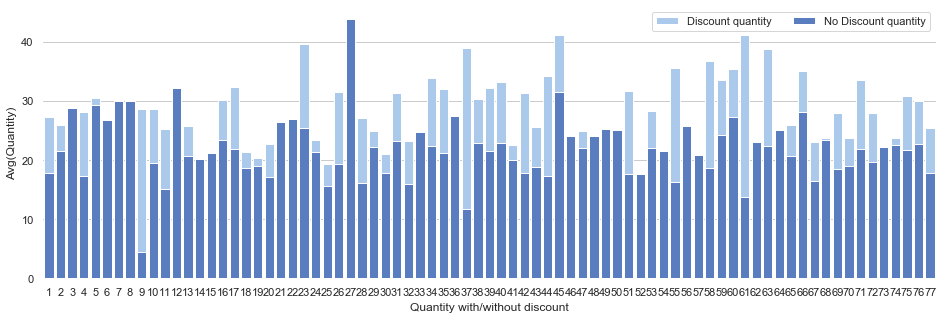

In [271]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes("pastel")
sns.barplot(x="ProductId", y="Avg(Quantity)", data=quantity_discount_df,
            label="Discount quantity", color="b")
sns.set_color_codes("muted")
sns.barplot(x="ProductId", y="Avg(Quantity)", data=quantity_nodiscount_df,
            label="No Discount quantity", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlabel="Quantity with/without discount")
sns.despine(left=True, bottom=True)

## Cohen_d

In [272]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return abs(d)

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- H0:there is no difference in order quantity due to discount
- H1:there is difference in order quantity due to discount

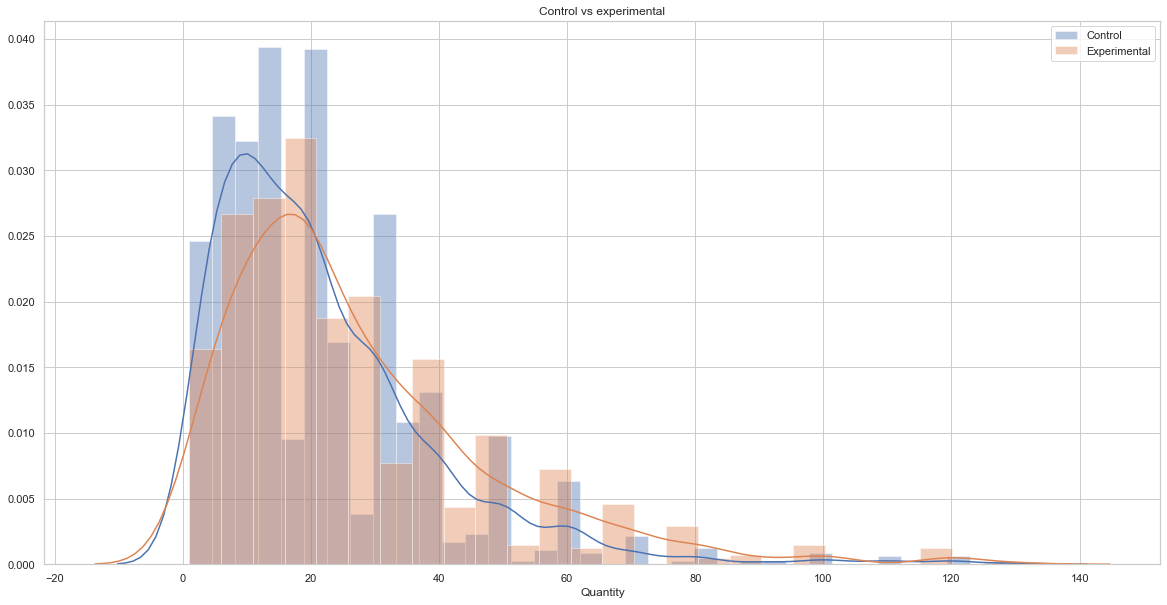

In [297]:
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']
plt.figure(figsize=(20, 10))
sns.distplot(control, label='Control')
sns.set_color_codes("muted")
sns.distplot(experimental, label='Experimental' )
plt.title('Control vs experimental')
plt.xlabel('Quantity')
plt.legend();

## Calculate the Cohen'd and p value

In [298]:
p = stats.ttest_ind(control, experimental, equal_var=False)[1]
d = Cohen_d(control, experimental)

In [300]:
print('p value is', p,'effective size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 5.65641429030433e-10 effective size is 0.2862724481729283
It has a small effect
Reject Null Hypothesis


## ANOVA

In [301]:
discount_list = [0,0.05,0.1,0.15,0.2,0.25]
combos = combinations(discount_list, 2)
# list(combos)

for combo in list(combos):
    discount1 = combo[0]
    discount2 = combo[1]
    sample1 = OrderDetail_df[OrderDetail_df['Discount']==discount1]['Quantity']
    sample2 = OrderDetail_df[OrderDetail_df['Discount']==discount2]['Quantity']
    p = stats.ttest_ind(sample1, sample2, equal_var=False)[1]
    d = Cohen_d(sample1, sample2)
    print(combo, 'p value is', p, 'effective size is', d)
    print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
# list(combos)

(0, 0.05) p value is 0.00027233494432847593 effective size is 0.3468767736284547
Reject Null Hypothesis
(0, 0.1) p value is 0.0374559661063408 effective size is 0.19594203057834103
Failed to reject Null Hypothesis
(0, 0.15) p value is 0.00017220729443627393 effective size is 0.3724041317472811
Reject Null Hypothesis
(0, 0.2) p value is 0.0008110033254043408 effective size is 0.3007122542913555
Reject Null Hypothesis
(0, 0.25) p value is 0.00015923050922125637 effective size is 0.3665925565267444
Reject Null Hypothesis
(0.05, 0.1) p value is 0.22710466225198522 effective size is 0.12776889275589157
Failed to reject Null Hypothesis
(0.05, 0.15) p value is 0.873701937770792 effective size is 0.017179350730157583
Failed to reject Null Hypothesis
(0.05, 0.2) p value is 0.6551134299813659 effective size is 0.04764417968753249
Failed to reject Null Hypothesis
(0.05, 0.25) p value is 0.9205932482537716 effective size is 0.010785641985778001
Failed to reject Null Hypothesis
(0.1, 0.15) p value 

### 5%, 15%, 20%, 25% is most effetive discounts the shop should take

## Q2: does country has a statistically significant effect on the quantity of the product sales? if so, at what levels

In [304]:
cur.execute("""Select * 
               From [Order]
;""")
Order_df = pd.DataFrame(cur.fetchall())
Order_df.columns = [x[0] for x in cur.description]

In [305]:
Order_df

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico
826,11074,SIMOB,7,2014-05-06,2014-06-03,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
827,11075,RICSU,8,2014-05-06,2014-06-03,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
828,11076,BONAP,4,2014-05-06,2014-06-03,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,Western Europe,13008,France
